In [57]:
import numpy as np
import timeit

def solve_cen(matlist, acc):
    K = len(matlist)
    N = matlist[0][0].shape[0]
    
    # form aggregate matrices
    T1agg = matlist[0][0]
    T2agg = matlist[0][1]

    for k in range(1, K):
        Nk = T1agg.shape[0]

        matlist1 = [[ T1agg[i,j] * matlist[k][(j%N)%2] for j in range(Nk)]
                    for i in range(Nk)]
        matlist2 = [[ T2agg[i,j] * matlist[k][(j%N)%2] for j in range(Nk)]
                    for i in range(Nk)]

        T1agg = np.bmat(matlist1)
        T2agg = np.bmat(matlist2)

    Nagg = T1agg.shape[0]

    Vacc = np.array([acc( [n % N] * K ) for n in range(Nagg)]).reshape([-1,1])
    V = np.zeros(Vacc.shape)
        
    it = 0

    # value iteration
    while True:
        W = np.fmax(V, Vacc)

        Wa = np.array([T1agg.dot(W), T2agg.dot(W)])
        Vnew = Wa.max(axis=0)

        if np.amax(np.abs(Vnew-V)) < 1e-5:
            break
        V = Vnew      
        
        it += 1
    
    return V.flatten()

In [58]:
def get_estr(k, K):
    Widx = [chr(65 + i + 32*(i > k)) for i in range(K)]
    newWidx = [chr(65 + i + 32*(i > k)) for i in range(K)]
    
    newWidx[k] = chr(ord(Widx[k])+32)
    Tidx = ['U', chr(ord(Widx[k])+32), Widx[k]]
    Aidx = ['U', Widx[k-1]]
        
    return ''.join(Tidx) + ',' + ''.join(Aidx) + ',' + ''.join(Widx) + '->' + ''.join(newWidx)

def solve_seq(matlist_q, acc):
    K = len(matlist_q)
    N = matlist_q[0].shape[-1]
    
    V = np.zeros((N,) * K)
    
    Vacc = np.array([acc( [n % N] * K ) for n in range(N**K)]).reshape([-1,1])
    Vacc = Vacc.reshape( (N,) * K  )
    
    while True:

        W = np.fmax(V, Vacc)
        
        for k in range(K-1, 0, -1):
            estr = get_estr(k, K)           
            A_k_q = np.array([[km % 2==0 for km in range(N)], [km % 2==1 for km in range(N)]])
            W = np.einsum(estr, matlist_q[k], A_k_q, W)
        
        Wa = np.einsum('qaA,A...->qa...', matlist_q[0], W)
        Vnew = Wa.max(axis=0)

        if np.amax(np.abs(Vnew-V)) < 1e-5:
            break

        V = Vnew        

    return V

In [59]:
import time

def get_random(K, N):
    matlist = []
    matlist_q = []

    for i in range(K):
        T1 = np.bmat([[np.random.rand(N//3, N//3), np.random.rand(N//3, N//3), np.random.rand(N//3, N//3)],
                      [np.zeros((N//3, N//3)),     np.random.rand(N//3, N//3), np.zeros((N//3, N//3))],
                      [np.zeros((N//3, N//3)),     np.zeros((N//3, N//3)),     np.random.rand(N//3, N//3)]])
        T2 = np.bmat([[np.random.rand(N//3, N//3), np.random.rand(N//3, N//3), np.random.rand(N//3, N//3)],
                      [np.zeros((N//3, N//3)),     np.random.rand(N//3, N//3), np.zeros((N//3, N//3))],
                      [np.zeros((N//3, N//3)),     np.zeros((N//3, N//3)),     np.random.rand(N//3, N//3)]])

        # normalize
        T1 = np.linalg.inv(np.diag(T1.sum(axis=1).getA1())).dot(T1)
        T2 = np.linalg.inv(np.diag(T2.sum(axis=1).getA1())).dot(T2)

        matlist.append([T1, T2])
        matlist_q.append(np.array([T1, T2]))
    return matlist, matlist_q

NN = 2*3
KK = 8
num_trial = 1


# Reach last triple
acc2 = lambda n: n[-1] >= 2*(NN//3)

T_cen = []
T_seq = []

for K in range(2, KK+1):
    
    t_cen_trial = []
    t_seq_trial = []
    
    for T in range(num_trial):
               
        matlist, matlist_q = get_random(K, NN)
        
        if K < 6:
            tcen0 = time.time()
            Vcen = solve_cen(matlist, acc2)
            tcen1 = time.time() - tcen0
            t_cen_trial += [tcen1]
        
        tseq0 = time.time()
        Vseq = solve_seq(matlist_q, acc2).ravel()
        tseq1 = time.time() - tseq0
        t_seq_trial += [tseq1]
        
        if K < 6:
            np.testing.assert_almost_equal(Vcen, Vseq)
    
    T_cen += [np.sum(t_cen_trial) / num_trial]
    T_seq += [np.sum(t_seq_trial) / num_trial]
    
print T_cen
print T_seq

[0.0031340122222900391, 0.018682003021240234, 0.69684004783630371, 28.089839220046997, 0.0, 0.0, 0.0]
[0.0016381740570068359, 0.0017340183258056641, 0.012378931045532227, 0.038006067276000977, 0.15094494819641113, 0.84795498847961426, 6.8366038799285889]


['axis x line=bottom, every axis x label/.style={at={(current axis.south east)},anchor=west}']
Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


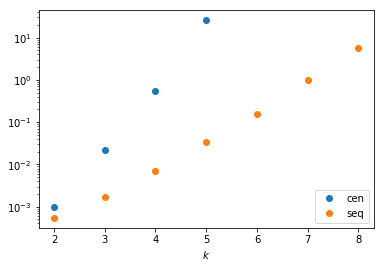

In [55]:
import matplotlib.pyplot as plt
from matplotlib2tikz import save as tikz_save

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

p_cen = ax.plot(range(2, 6), T_cen[:4], 'o', label='cen')
p_seq = ax.plot(range(2, 9), T_seq, 'o', label='seq')

ax.set_yscale('log')
ax.legend(['cen', 'seq'], loc=4)
plt.xlabel('$k$')

apar = ['axis x line=bottom, every axis x label/.style={at={(current axis.south east)},anchor=west}']
print apar

tikz_save('scale.tex', figure=fig, figurewidth='\\figurewidth', figureheight='\\figureheight')